In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import math as math
from sklearn.neighbors import NearestNeighbors
import sklearn as skl
from sklearn.metrics import f1_score

In [2]:
DATA_DIR = 'MNIST'
STEPS = 200
MINIBATCH_SIZE = 50

imgDim = 28
imgChannels = 1

input_feature_width = imgDim * imgDim
number_of_outputs = input_feature_width
num_hidden_units = 2
learning_rate = 0.01

In [3]:
def get_data(mnist):
    batch = mnist.test.next_batch(2000)
    stratified_data, stratified_labels = get_stratified_data(batch[0], batch[1], 100)
    #print(stratified_data)
    #print(len(stratified_data))
    #print(batch[0].shape)
    #images = batch[0].reshape(1000, 784)
    return stratified_data, stratified_labels


def get_stratified_data(data, labels, min_size):
    labels = np.array([np.where(r==1)[0][0] for r in labels ])
    ret_data = {}
    _data = []
    _labels = []
    #print(labels.shape)
    for i in range(len(data)):
        if not int(labels[i]) in ret_data:
            ret_data[int(labels[i])] = 1
        else:
            if(ret_data[int(labels[i])] <= min_size):
                ret_data[int(labels[i])] += 1
                _data.append(data[i])
                _labels.append(int(labels[i]))
            else:
                pass
                #print(str(int(labels[i])) + " has " + str(min_size))
    return _data, np.array(_labels)
    


In [4]:
l2_reg = 0.0001
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(tf.float32, shape=[None, input_feature_width])
hidden = tf.layers.dense(X, num_hidden_units, activation=tf.nn.elu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
output = tf.layers.dense(hidden, number_of_outputs, activation=None, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
reconstruction_loss = tf.reduce_mean(tf.square(output - X))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [5]:
init = tf.global_variables_initializer()

In [6]:
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)
X_train, labels = get_data(mnist)
codings = hidden
reconstuction_loss_values = []

with tf.Session() as sess:
    init.run()
    for iteration in range(STEPS):
        training_op.run(feed_dict={X:X_train})
        reconstuction_loss_values.append(reconstruction_loss.eval(feed_dict={X:X_train}))
    data_points = codings.eval(feed_dict={X:X_train})
    data = X_train[0].reshape(1,input_feature_width)
    codings_val1 = codings.eval(feed_dict={X:data})
    #print(codings_val1)


Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


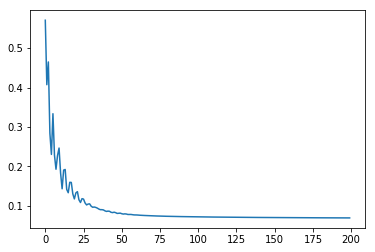

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(reconstuction_loss_values)


# Reconstruction loss plotted as above

In [8]:
print(labels.shape)
print(labels[10])
integer_labels = labels #np.array([np.where(r==1)[0][0] for r in labels ])
print(integer_labels[34])
print(integer_labels.shape)


(1000,)
8
8
(1000,)


In [9]:
def get_k_nearest_neighbor_indices(input_data, number_of_neighbors, index_of_the_target_node = 0):
    nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='brute').fit(input_data)
    distances, indices = nbrs.kneighbors(input_data)
    return indices[index_of_the_target_node]

def get_metrics_for_label(number_to_show_for):
    index_of_target_node = np.where(integer_labels == number_to_show_for)[0][0]
    label_of_target_node = integer_labels[index_of_target_node]
    k_nearest_neighbor_indices = get_k_nearest_neighbor_indices(data_points, 50, index_of_target_node)
    predictions = map(lambda index: integer_labels[index], k_nearest_neighbor_indices)
    truth = np.ones((50)) * label_of_target_node

    intLabelling = np.vectorize(lambda x: int(x))
    truth = intLabelling(truth)
    f1 = skl.metrics.f1_score(truth, predictions, average='micro')  
    precision = skl.metrics.precision_score(truth, predictions, average='micro')
    recall = skl.metrics.recall_score(truth, predictions, average='micro')
    return precision, recall, f1

number_chosen = 5
print("Precision and Recall for the number %d" %(number_chosen))
precision, recall, f1 = get_metrics_for_label(number_chosen)
print('\nTest Precision=%.2f' % (precision))
print('Test Recall=%.2f' % (recall))
print('Test F1 Score=%.2f' % (f1))

l = []
p = []
r = []
f = []
for i in range(10):
    _p , _r , _f = get_metrics_for_label(i)
    l.append(i)
    p.append(_p)
    r.append(_r)
    f.append(_f)
    




Precision and Recall for the number 5

Test Precision=0.14
Test Recall=0.14
Test F1 Score=0.14


# Precision and Recall for all numbers plotted below

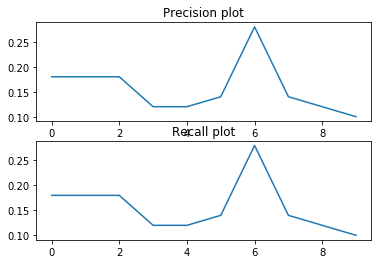

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1)

ax = plt.subplot(211)
ax.set_title("Precision plot")
plt.plot(l,p)
ax = plt.subplot(212)
ax.set_title("Recall plot")
plt.plot(l,r)